# All Things Data

In [44]:
import os
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [45]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

## Loading

In [46]:
emotions = {
    0:'no_emotion',
    1:'anger',
    2:'disgust',
    3:'fear',
    4:'happiness',
    5:'sadness',
    6:'surprise',
    7: 'shame'
}

In [47]:
dataset_directory_path = 'full_dataset'

dataframes = []

csv_files = [file for file in os.listdir(dataset_directory_path) if file.endswith('.csv')]

In [48]:
file_path = os.path.join(dataset_directory_path, 'isear.csv')
df = pd.read_csv(file_path)
df['Emotion'] = df['Emotion'].replace('joy', 'happiness')
df.rename(columns={'Emotion': 'emotion'}, inplace=True)
df.rename(columns={'Text': 'text'}, inplace=True)
dataframes.append(df)
df.emotion.value_counts()

emotion
happiness    1081
fear         1081
anger        1071
sadness      1067
disgust      1067
shame        1054
guilt        1052
Name: count, dtype: int64

In [49]:
file_path = os.path.join(dataset_directory_path, 'emotion-stimulus.csv')
df = pd.read_csv(file_path)
df['Emotion'] = df['Emotion'].replace('sad', 'sadness')
df['Emotion'] = df['Emotion'].replace('happy', 'happiness')
df.rename(columns={'Emotion': 'emotion'}, inplace=True)
df.rename(columns={'Text': 'text'}, inplace=True)
dataframes.append(df)
df.emotion.value_counts()

emotion
sadness      575
anger        483
happiness    479
fear         423
surprise     213
shame        146
disgust       95
Name: count, dtype: int64

In [50]:
merged_df = pd.concat(dataframes, axis=0, ignore_index=True)
merged_df.head(n=5)

,emotion,text
0,happiness,"During the period of falling in love, each tim..."
1,fear,When I was involved in a traffic accident.
2,anger,When I was driving home after several days of...
3,sadness,When I lost the person who meant the most to me.
4,disgust,The time I knocked a deer down - the sight of ...


In [51]:
merged_df.emotion.value_counts()

emotion
sadness      1642
happiness    1560
anger        1554
fear         1504
shame        1200
disgust      1162
guilt        1052
surprise      213
Name: count, dtype: int64

In [52]:
print("Columns:")
for c in merged_df.columns.tolist():
    print("\t", c)

Columns:
	 emotion
	 text


In [53]:
print("All emotions:")
emotions = []
for e in merged_df['emotion'].unique():
    if e not in ['text', 'id']:
        print("\t", e)
        emotions.append(e)

All emotions:
	 happiness
	 fear
	 anger
	 sadness
	 disgust
	 shame
	 guilt
	 surprise


In [54]:
print("Number of rows = ", merged_df.shape[0])

Number of rows =  9887


In [55]:
print("Number of columns = ", merged_df.shape[1])

Number of columns =  2


## Preprocessing

In [56]:
def cleanText(text):
    text = text.lower()

    # Remove links
    text = re.sub(r"http\S*|\S*\.com\S*|\S*www\S*", " ", text)

    # Remove @mentions
    text = re.sub(r"\s@\S+", " ", text)

    # Remove all punctuation
    punctuation_table = str.maketrans("", "", string.punctuation)
    text = text.translate(punctuation_table)

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [token for token in tokens if len(token)>2]

    return tokens

In [57]:
tqdm.pandas(desc="Processing text")
dataframe = merged_df.copy()
dataframe['preprocessed_text'] = dataframe['text'].progress_apply(cleanText)

Processing text: 100%|██████████| 9887/9887 [00:03<00:00, 2983.78it/s]


In [58]:
dataframe.rename(columns={'text': 'original_text'}, inplace=True)
dataframe.rename(columns={'preprocessed_text': 'text_tokens'}, inplace=True)
dataframe['preprocessed_text'] = dataframe['text_tokens'].apply(lambda x: ' '.join(x)).astype(str)

In [59]:
dataframe

,emotion,original_text,text_tokens,preprocessed_text
0,happiness,"During the period of falling in love, each tim...","[period, falling, love, time, met, especially,...",period falling love time met especially met lo...
1,fear,When I was involved in a traffic accident.,"[involved, traffic, accident]",involved traffic accident
2,anger,When I was driving home after several days of...,"[driving, home, several, day, hard, work, moto...",driving home several day hard work motorist ah...
3,sadness,When I lost the person who meant the most to me.,"[lost, person, meant]",lost person meant
4,disgust,The time I knocked a deer down - the sight of ...,"[time, knocked, deer, sight, animal, injury, h...",time knocked deer sight animal injury helpless...
...,...,...,...,...
9882,shame,He gets real humiliated and has to leave .,"[get, real, humiliated, leave]",get real humiliated leave
9883,shame,They aimed for higher status jobs and felt hum...,"[aimed, higher, status, job, felt, humiliated,...",aimed higher status job felt humiliated unempl...
9884,shame,He cursed his lack of self-control ; he knew t...,"[cursed, lack, selfcontrol, knew, old, biddy, ...",cursed lack selfcontrol knew old biddy seen fe...
9885,shame,Sometimes I've thought I 'll never forget wha...,"[sometimes, ive, thought, never, forget, happe...",sometimes ive thought never forget happened co...


In [60]:
dataframe.isnull().sum()

emotion              0
original_text        0
text_tokens          0
preprocessed_text    0
dtype: int64

In [62]:
# uklanjanje duplikata
indexes = dataframe[dataframe['original_text'].duplicated() ==  True].index
dataframe.drop(indexes, axis=0, inplace=True)

In [78]:
duplicated_rows = dataframe.duplicated(subset=['original_text'], keep=False)

# maska za one koji imaju isti 'original_text' ali razliciti 'emotion'
mask = ~duplicated_rows | (duplicated_rows & dataframe.duplicated(subset=['original_text', 'emotion']))

# Apply the mask to the DataFrame
filtered_df = dataframe[mask]

dataframe

,emotion,original_text,text_tokens,preprocessed_text
0,happiness,"During the period of falling in love, each tim...","[period, falling, love, time, met, especially,...",period falling love time met especially met lo...
1,fear,When I was involved in a traffic accident.,"[involved, traffic, accident]",involved traffic accident
2,anger,When I was driving home after several days of...,"[driving, home, several, day, hard, work, moto...",driving home several day hard work motorist ah...
3,sadness,When I lost the person who meant the most to me.,"[lost, person, meant]",lost person meant
4,disgust,The time I knocked a deer down - the sight of ...,"[time, knocked, deer, sight, animal, injury, h...",time knocked deer sight animal injury helpless...
...,...,...,...,...
9882,shame,He gets real humiliated and has to leave .,"[get, real, humiliated, leave]",get real humiliated leave
9883,shame,They aimed for higher status jobs and felt hum...,"[aimed, higher, status, job, felt, humiliated,...",aimed higher status job felt humiliated unempl...
9884,shame,He cursed his lack of self-control ; he knew t...,"[cursed, lack, selfcontrol, knew, old, biddy, ...",cursed lack selfcontrol knew old biddy seen fe...
9885,shame,Sometimes I've thought I 'll never forget wha...,"[sometimes, ive, thought, never, forget, happe...",sometimes ive thought never forget happened co...


In [64]:
dataframe = filtered_df

In [65]:
dataframe.shape

(9806, 4)

In [66]:
csv_path = 'full_dataset/full_dataset.csv'
dataframe.to_csv(csv_path, index=False)
print(f'DataFrame saved to: {csv_path}')

DataFrame saved to: full_dataset/full_dataset.csv


## EDA

In [67]:
csv_path = 'full_dataset/full_dataset.csv'

In [68]:
data = pd.read_csv(csv_path)

In [69]:
data.head(n=-1)

,emotion,original_text,text_tokens,preprocessed_text
0,happiness,"During the period of falling in love, each tim...","['period', 'falling', 'love', 'time', 'met', '...",period falling love time met especially met lo...
1,fear,When I was involved in a traffic accident.,"['involved', 'traffic', 'accident']",involved traffic accident
2,anger,When I was driving home after several days of...,"['driving', 'home', 'several', 'day', 'hard', ...",driving home several day hard work motorist ah...
3,sadness,When I lost the person who meant the most to me.,"['lost', 'person', 'meant']",lost person meant
4,disgust,The time I knocked a deer down - the sight of ...,"['time', 'knocked', 'deer', 'sight', 'animal',...",time knocked deer sight animal injury helpless...
...,...,...,...,...
9800,shame,` When Liz came back there was raucous laughte...,"['liz', 'came', 'back', 'raucous', 'laughter',...",liz came back raucous laughter felt humiliated
9801,shame,He gets real humiliated and has to leave .,"['get', 'real', 'humiliated', 'leave']",get real humiliated leave
9802,shame,They aimed for higher status jobs and felt hum...,"['aimed', 'higher', 'status', 'job', 'felt', '...",aimed higher status job felt humiliated unempl...
9803,shame,He cursed his lack of self-control ; he knew t...,"['cursed', 'lack', 'selfcontrol', 'knew', 'old...",cursed lack selfcontrol knew old biddy seen fe...


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9806 entries, 0 to 9805
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   emotion            9806 non-null   object
 1   original_text      9806 non-null   object
 2   text_tokens        9806 non-null   object
 3   preprocessed_text  9806 non-null   object
dtypes: object(4)
memory usage: 306.6+ KB


In [71]:
data = data.dropna(subset=['preprocessed_text'])

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9806 entries, 0 to 9805
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   emotion            9806 non-null   object
 1   original_text      9806 non-null   object
 2   text_tokens        9806 non-null   object
 3   preprocessed_text  9806 non-null   object
dtypes: object(4)
memory usage: 306.6+ KB


In [73]:
data.to_csv(csv_path, index=False)
print(f'DataFrame saved to: {csv_path}')

DataFrame saved to: full_dataset/full_dataset.csv


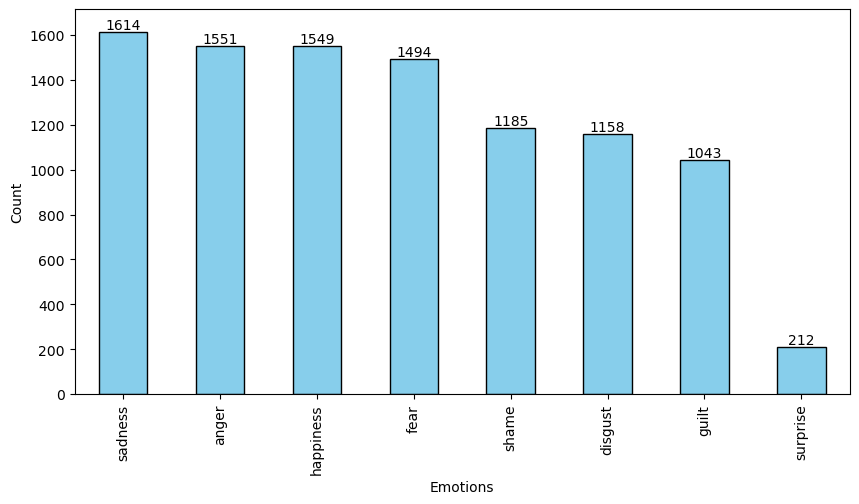

In [74]:
plt.figure(figsize=(10, 5))

emotion_counts = data['emotion'].value_counts()

ax = emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()+12), ha='center', va='baseline')

plt.ylim(0, max(emotion_counts) + 100)
plt.xlabel('Emotions')
plt.ylabel('Count')

plt.show()

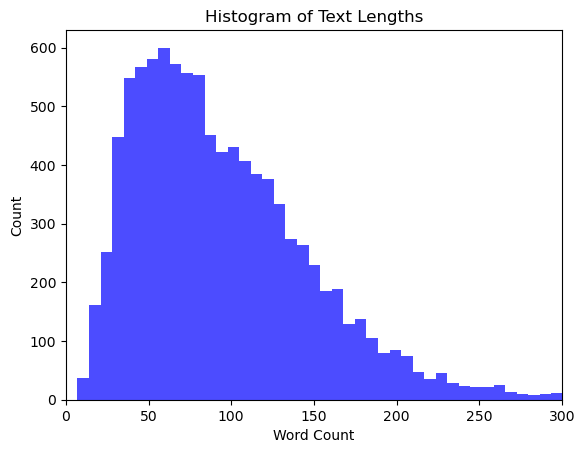

In [75]:
text_length = data['text_tokens'].apply(len)

plt.hist(text_length, bins=100, color='blue', alpha=0.7)
plt.xlim(0, 300)
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Histogram of Text Lengths')
plt.show()

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9806 entries, 0 to 9805
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   emotion            9806 non-null   object
 1   original_text      9806 non-null   object
 2   text_tokens        9806 non-null   object
 3   preprocessed_text  9806 non-null   object
dtypes: object(4)
memory usage: 306.6+ KB
